In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date< '2017-08-23')

# Calculate the date 1 year ago from the last data point in the database
year_ago=dt.date.today()- dt.timedelta(days=365)
query_date=dt.date(2017, 8, 23)- dt.timedelta(days=365)
    #print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= '2016-08-23').filter(Measurement.date <='2017-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
query_results_df=pd.DataFrame(results, columns=['date','prcp'])
query_results_df.set_index('date', inplace=True)
query_results_df.rename(columns={'prcp': 'precipitation'}, inplace=True)
query_results_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


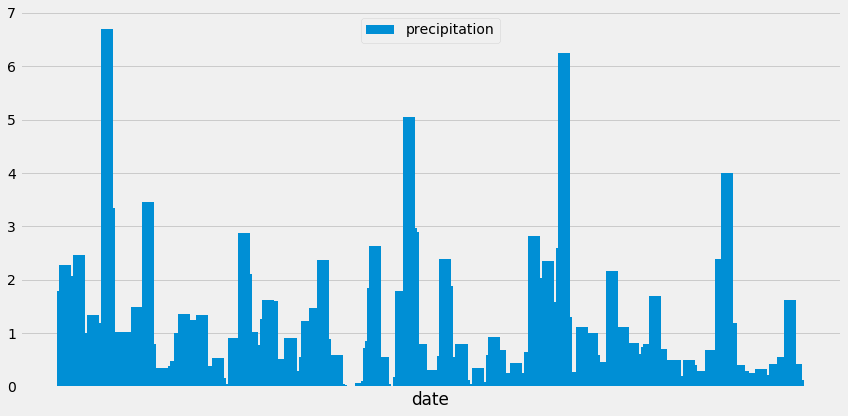

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure (figsize=(12,6))
plt.bar(query_results_df.index, query_results_df['precipitation'], width=6, label='precipitation')
plt.xticks([])
plt.legend(loc='upper center')
plt.grid(True)
plt.xlabel('date')
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats=query_results_df.describe()
summary_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(Station.station)).all()
station_count

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel=[Measurement.station, func.count(Measurement.station)]

active_stations=session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
#Most active station 
station_most_active=active_stations[0][0]
print(station_most_active)

#Using the station id from the previous query, calculate the lowest temperature recorded, 
#highest temperature recorded, and average temperature of the most active station?

sel=[Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

active_station_results=session.query(*sel).\
    filter(Measurement.station==station_most_active).all()

active_station_results

print(f"Most active station: {station_most_active}, Low temp: {active_station_results[0][1]}, High temp: {active_station_results[0][2]}, Avg temp: {(round(active_station_results[0][3], 2))}")


USC00519281
Most active station: USC00519281, Low temp: 54.0, High temp: 85.0, Avg temp: 71.66


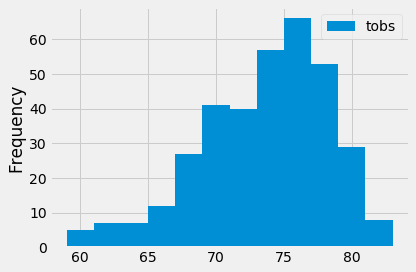

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram.

highest_number_obs=session.query(Measurement.tobs).\
    filter(Measurement.station==station_most_active).\
    filter(Measurement.date>= query_date).all()
highest_number_obs

highest_obs_results=pd.DataFrame(highest_number_obs, columns=['tobs'])
highest_obs_results.head()

highest_obs_results.plot.hist(highest_obs_results, bins=12)
plt.grid(True)
plt.tight_layout()

In [17]:
## Optional Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

min_temp, avg_temp, max_temp=calc_temps('2016-05-04', '2016-05-11')[0]
print(min_temp, avg_temp, max_temp)

66.0 72.3265306122449 77.0


/opt/anaconda3/envs/PythonData3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


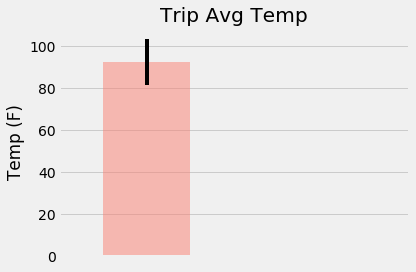

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig,ax=plt.subplots()
figsize=(3,5)
y_value=(avg_temp+20)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp (F)")
yerr=(max_temp-min_temp)

bar=ax.bar(1, y_value, width=1, yerr=yerr, color='salmon', alpha=0.5)
ax.set_xlim(0,4)
ax.set_xticklabels('')
ax.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax.grid(axis='x')
fig.tight_layout()
fig.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date= '2016-05-04'
end_date='2016-05-11'

total_rainfall=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

total_rainfall_results=session.query(*total_rainfall).\
    filter(Measurement.station==Station.station).\
    filter(Measurement.date>=start_date).\
    filter(Measurement.date<=end_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

total_rainfall_results

[('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  3.5399999999999996),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.4899999999999998),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.0900000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.8400000000000003),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.92),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [22]:
## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
